In [1]:
from gala import evaluate as ev, imio, viz, morpho, classify, features, agglo

from skimage.util import regular_seeds

import numpy as np
import os

os.chdir('../../research_project_files/')
raw, gt = imio.read_cremi("Cremi_Data/sample_B_20160501.hdf", datasets=['volumes/raw', 'volumes/labels/neuron_ids'])

from matplotlib import pyplot as plt
import holoviews as hv
import ipyvolume as ipy
%matplotlib inline

In [4]:
gt_larger = gt[0:8, 0:120, 0:120]
raw_larger = raw[0:8, 0:120, 0:120]
raw_larger_testing = 1-raw[0:8, 120:240, 120:240]/255
gt_larger_testing = gt[0:8, 120:240, 120:240]
ws_larger_seeds = regular_seeds(raw_larger[0].shape, n_points=360)
ws_larger_seeds = np.broadcast_to(ws_larger_seeds, raw_larger.shape)
ws_larger_testing = morpho.watershed_sequence(raw_larger_testing, ws_larger_seeds, n_jobs=-1)
fm = features.moments.Manager()
fh = features.histogram.Manager()
fc = features.base.Composite(children=[fm, fh])
g_train_larger = agglo.Rag(ws_larger_testing, raw_larger, feature_manager=fc)
(X2, y2, w2, merges2) = g_train_larger.learn_agglomerate(gt_larger, fc, classifier='logistic')[0]
y2 = y2[:, 0]
rf_log_large = classify.get_classifier('logistic').fit(X2,y2)
learned_policy_large = agglo.classifier_probability(fc, rf_log_large)
g_test_large = agglo.Rag(ws_larger_testing, raw_larger_testing, feature_manager=fc, merge_priority_function=learned_policy_large)
g_test_large.agglomerate(np.inf)
seg_stack_large = [g_test_large.get_segmentation(t) for t in np.arange(0,1, 0.05)]

100%|██████████| 3199/3199 [00:02<00:00, 1113.44it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [14]:
viz.draw_seg?

In [16]:
_, bins = np.histogram(sparse_seg, bins=255)
volume0 = np.clip(np.digitize(sparse_seg, bins), 0, 255).astype(np.uint8)

In [20]:
np.argsort(np.bincount(gt_raw.astype(int).ravel()))[-10:]

array([  1871,  73394,  20423,   1811,   1860,  39717,   1852,  33161,
       105220,   1771])

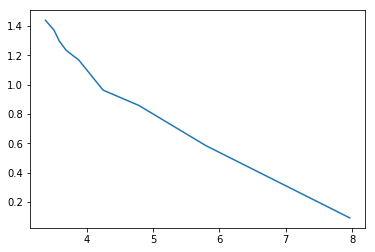

In [5]:
%matplotlib inline
split_vi_score_large = [ev.split_vi(seg_stack_large[t], gt_larger_testing) for t in range(len(seg_stack_large))]
split_vi_array = np.array(split_vi_score_large)
fig, ax = plt.subplots()
ax.plot(split_vi_array[:, 1], split_vi_array[:, 0], label="number of seed points")

In [85]:
from skimage import io
#io.imsave(fname="raw_slice_1.tiff", arr=raw)

In [53]:
from operator import itemgetter
a,b = map(itemgetter(0),split), map(itemgetter(1),split)

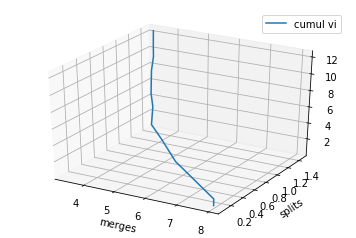

In [13]:
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['legend.fontsize'] = 10
fig = plt.figure()
ax = fig.gca(projection='3d')
cum_score_arr = np.array(np.cumsum(split_vi_array, axis=0))
ax.plot(split_vi_array[:, 1], split_vi_array[:, 0], cum_score_arr[:, 0], label="cumul vi")
ax.legend()
plt.xlabel("merges")
plt.ylabel("splits")
plt.show()

In [47]:
a = hv.Scatter3D(raw_larger_testing)

In [ ]:
from skimage import img_as_ubyte

target_segs = np.argsort(np.bincount(seg_stack_large_2[19].astype(int).ravel()))[-10:]
extracted_seg= imio.extract_segments(seg_stack_large_2[19], ids=target_segs)
imio.write_vtk(extracted_seg, fn='extraced_seg_5_10.vtk',spacing=[4, 4, 40])
imio.write_vtk(gt_larger_2,fn='extraced_gt_5_10.vtk',spacing=[4, 4, 40])
imio.write_vtk(img_as_ubyte(raw_larger_2),fn='extraced_raw_5_10.vtk',spacing=[4, 4, 40])

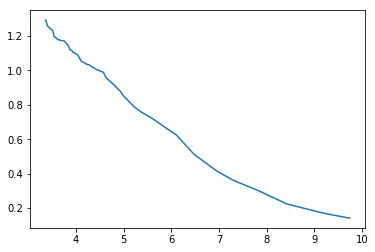

In [98]:
cont_a = [ev.contingency_table(seg_stack_large_2[index], gt_larger_2) for index,_ in enumerate(seg_stack_large_2)]
cont_stack = [ev.split_vi(cont_a[i]) for i,_ in enumerate(cont_a)]
split_vi_array_new = np.array(cont_stack)
fig, ax = plt.subplots()
ax.plot(split_vi_array_new[:, 1], split_vi_array_new[:, 0])

In [110]:
from skimage import io
io.imsave(fname="raw_larger_2.tiff", arr=raw_larger_2)
gg = np.argsort(np.bincount(gt_larger_2.astype(int).ravel()))[-10:]
sparse_large = imio.extract_segments(gt_larger_2, ids = gg)
imio.write_vtk(raw_larger_2,fn ="raw_cropped_newest.vtk", spacing=[4, 4, 40])
imio.write_vtk(sparse_large,fn ="sparse_gt_newest.vtk", spacing=[4, 4, 40])

In [ ]:
from gala import evaluate as ev, imio, viz, morpho, agglo, classify, features
from skimage.util import regular_seeds
from skimage import io
import numpy as np
from matplotlib import pyplot as plt
raw, gt = imio.read_cremi("Cremi_Data/sample_B_20160501.hdf", datasets=['volumes/raw', 'volumes/labels/neuron_ids'])
bpm = imio.read_h5_stack('raw_slice_1_Probabilities.h5', group='bpm_raw_b')
membrane_prob = bpm[..., 2]
train_slice = (slice(0, 15), slice(0, 480), slice(0, 480))
test_slice = (slice(0, 15), slice(480, 960), slice(480, 960))
gt_larger_2 = gt[train_slice]
raw_larger_2 = 1-raw[train_slice]/255
ws_larger_seeds_2 = regular_seeds(raw_larger_2[0].shape, n_points=700)
ws_larger_seeds_2 = np.broadcast_to(ws_larger_seeds_2, raw_larger_2.shape)
ws_larger_water = morpho.watershed_sequence(membrane_prob[train_slice], ws_larger_seeds_2, n_jobs=-1)
raw_larger_testing_2 = membrane_prob[test_slice]
gt_larger_testing_2 = gt[test_slice]
gg = np.argsort(np.bincount(gt_larger_2.astype(int).ravel()))[-10:]
sparse_large = imio.extract_segments(gt_larger_2, ids = gg)
ws_larger_testing_2 = morpho.watershed_sequence(raw_larger_testing_2, ws_larger_seeds_2, n_jobs=-1)
fm = features.moments.Manager()
fh = features.histogram.Manager()
fc = features.base.Composite(children=[fm, fh])
g_train_larger_2 = agglo.Rag(ws_larger_water, bpm[train_slice], feature_manager=fc)
(X2, y2, w2, merges2) = g_train_larger_2.learn_agglomerate(gt_larger_2, fc, classifier='logistic')[0]
y2 = y2[:, 0]
rf_log_large_2 = classify.get_classifier('logistic').fit(X2,y2)
learned_policy_large_2 = agglo.classifier_probability(fc, rf_log_large_2)
g_test_large_2 = agglo.Rag(ws_larger_testing_2, bpm[test_slice], feature_manager=fc, merge_priority_function=learned_policy_large_2)
g_test_large_2.agglomerate(np.inf)
seg_stack_large_2 = [g_test_large_2.get_segmentation(t) for t in np.arange(0,1, 0.01)]
split_vi_score_large_2 = [ev.split_vi(seg_stack_large_2[t], gt_larger_testing_2) for t in range(len(seg_stack_large_2))]
split_vi_array_2 = np.array(split_vi_score_large_2)
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
ax0.plot(split_vi_array_2[:, 1], split_vi_array_2[:, 0])
target_segs = np.argsort(np.bincount(seg_stack_large_2[9].astype(int).ravel()))[-10:]
ax1.plot(split_vi_array_2.sum(axis=1))
ax.set_aspect(1)
ax2.imshow(raw_larger_2[0], alpha=1, cmap='gray')

100%|██████████| 10934/10934 [01:02<00:00, 176.19it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?i

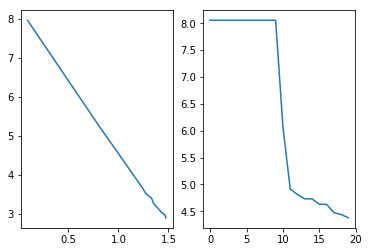

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(split_vi_array[:, 0], split_vi_array[:, 1])
target_segs = np.argsort(np.bincount(seg_stack_large[9].astype(int).ravel()))[-10:]
ax[1].plot(split_vi_array.sum(axis=1))

In [33]:
np.argmin(split_vi_array.sum(axis=1))

19

In [32]:
np.argsort(split_vi_array.sum(axis=1))

array([19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  0,  7,  6,  5,  4,  3,  2,
        1,  8,  9])

In [38]:
list(map(len, (split_vi_array[:, 1], split_vi_array[:, 0], np.cumsum(split_vi_array, axis=0))))

[20, 20, 20]